# Import Libraries

In [1]:
!git clone https://github.com/venkyyuvy/image_classifier.git

Cloning into 'image_classifier'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 84 (delta 43), reused 65 (delta 25), pack-reused 0
Unpacking objects: 100% (84/84), 779.81 KiB | 9.75 MiB/s, done.


In [2]:
cd image_classifier/S7

/content/image_classifier/S7


In [ ]:
! nvidia-smi

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=([1, 1, 1,])),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

batch_size=256
kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 2,
    'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
kwargs['shuffle']= False
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def get_layer(layer_type, in_channel=None, out_channel=None,
              dropout_value=0.05):
    norm_map = {'batch': nn.BatchNorm2d,
     'layer': nn.LayerNorm(batch_size),
     'group': nn.GroupNorm} #norm_layer(4, out_channel),

    # norm_layer = norm_map[norm]
    if layer_type == 'C':
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channel,
                      out_channels=out_channel,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4, out_channel),
            nn.Dropout(dropout_value)
        )
    elif layer_type == 'c':
        return nn.Conv2d(in_channels=in_channel,
                        out_channels=out_channel,
                        kernel_size=(1, 1), padding=0, bias=False)
    elif layer_type == 'P':
        return nn.MaxPool2d(2, 2)
    elif layer_type == 'G':
        return nn.AdaptiveAvgPool2d(output_size=1)

In [5]:
class Net(nn.Module):
    def __init__(self, schema, channels, dropout_value=0.01):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        for layer_type, channel_in, channel_out in zip(
            schema, [3, *channels], channels):
            self.layers.append(get_layer(
                layer_type, channel_in, channel_out,
                dropout_value))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [21]:
model.layers[0][0].weight.device

device(type='cpu')

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
device='mps:0'
print(device)
model = Net(
    list('CCcPCCCcPCCCGc'),
    [64, 32, 16, 16,
     8, 16, 16, 32, 32,
     8, 16, 32, 32, 10]).to(device)
summary(model.to('cpu'), input_size=(3, 32, 32), device='cpu')


mps:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
         GroupNorm-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]          18,432
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11            [-1, 8, 16, 16]           1,152
             ReLU-12            [-1, 8, 16, 16]               0
        GroupNorm-13            [-1, 8, 16, 16]              16
          Dropout-14            [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

# Let's Train and test our model

In [22]:
model = Net(
    list('CCcPCCCcPCCCGc'),
    [64, 32, 16, 16,
     8, 16, 16, 32, 32,
     8, 16, 32, 32, 10]).to('mps:0')

In [23]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from model import train, test

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.05)

EPOCHS =  20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

EPOCH: 0


Loss=1.724265456199646 Batch_id=195 Accuracy=27.05: 100%|██████████| 196/196 [00:35<00:00,  5.54it/s] 



Test set: Average loss: 1.7336, Accuracy: 3646/10000 (36.46%)

EPOCH: 1


Loss=1.4324696063995361 Batch_id=195 Accuracy=41.98: 100%|██████████| 196/196 [00:24<00:00,  7.85it/s]



Test set: Average loss: 1.4565, Accuracy: 4660/10000 (46.60%)

EPOCH: 2


Loss=1.3120355606079102 Batch_id=195 Accuracy=50.42: 100%|██████████| 196/196 [00:26<00:00,  7.38it/s]



Test set: Average loss: 1.3580, Accuracy: 5053/10000 (50.53%)

EPOCH: 3


Loss=1.2118993997573853 Batch_id=195 Accuracy=55.66: 100%|██████████| 196/196 [00:26<00:00,  7.45it/s]



Test set: Average loss: 1.2599, Accuracy: 5450/10000 (54.50%)

EPOCH: 4


Loss=1.2679697275161743 Batch_id=195 Accuracy=60.26: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 1.0859, Accuracy: 6122/10000 (61.22%)

EPOCH: 5


Loss=1.1732488870620728 Batch_id=195 Accuracy=61.42: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 1.0795, Accuracy: 6117/10000 (61.17%)

EPOCH: 6


Loss=1.169724702835083 Batch_id=195 Accuracy=61.89: 100%|██████████| 196/196 [00:25<00:00,  7.65it/s] 



Test set: Average loss: 1.0698, Accuracy: 6164/10000 (61.64%)

EPOCH: 7


Loss=0.9306310415267944 Batch_id=195 Accuracy=62.28: 100%|██████████| 196/196 [00:26<00:00,  7.38it/s]



Test set: Average loss: 1.0685, Accuracy: 6168/10000 (61.68%)

EPOCH: 8


Loss=0.9630191922187805 Batch_id=195 Accuracy=62.61: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 1.0619, Accuracy: 6190/10000 (61.90%)

EPOCH: 9


Loss=1.0391228199005127 Batch_id=195 Accuracy=62.39: 100%|██████████| 196/196 [00:26<00:00,  7.39it/s]



Test set: Average loss: 1.0622, Accuracy: 6186/10000 (61.86%)

EPOCH: 10


Loss=1.2322075366973877 Batch_id=195 Accuracy=62.57: 100%|██████████| 196/196 [00:26<00:00,  7.32it/s]



Test set: Average loss: 1.0612, Accuracy: 6200/10000 (62.00%)

EPOCH: 11


Loss=1.0008989572525024 Batch_id=195 Accuracy=62.54: 100%|██████████| 196/196 [00:25<00:00,  7.58it/s]



Test set: Average loss: 1.0614, Accuracy: 6205/10000 (62.05%)

EPOCH: 12


Loss=1.0796979665756226 Batch_id=195 Accuracy=62.32: 100%|██████████| 196/196 [00:26<00:00,  7.48it/s]



Test set: Average loss: 1.0612, Accuracy: 6203/10000 (62.03%)

EPOCH: 13


Loss=0.988880455493927 Batch_id=158 Accuracy=62.50:  81%|████████  | 159/196 [00:14<00:02, 16.36it/s] 

In [ ]:
import pandas as pd
results_df = []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred_label = output.argmax(dim=1)
    results_df.append(
        pd.DataFrame({"prediction": pred_label,
                      "target": target}))

df = pd.concat(results_df).reset_index(drop=True)

Files already downloaded and verified


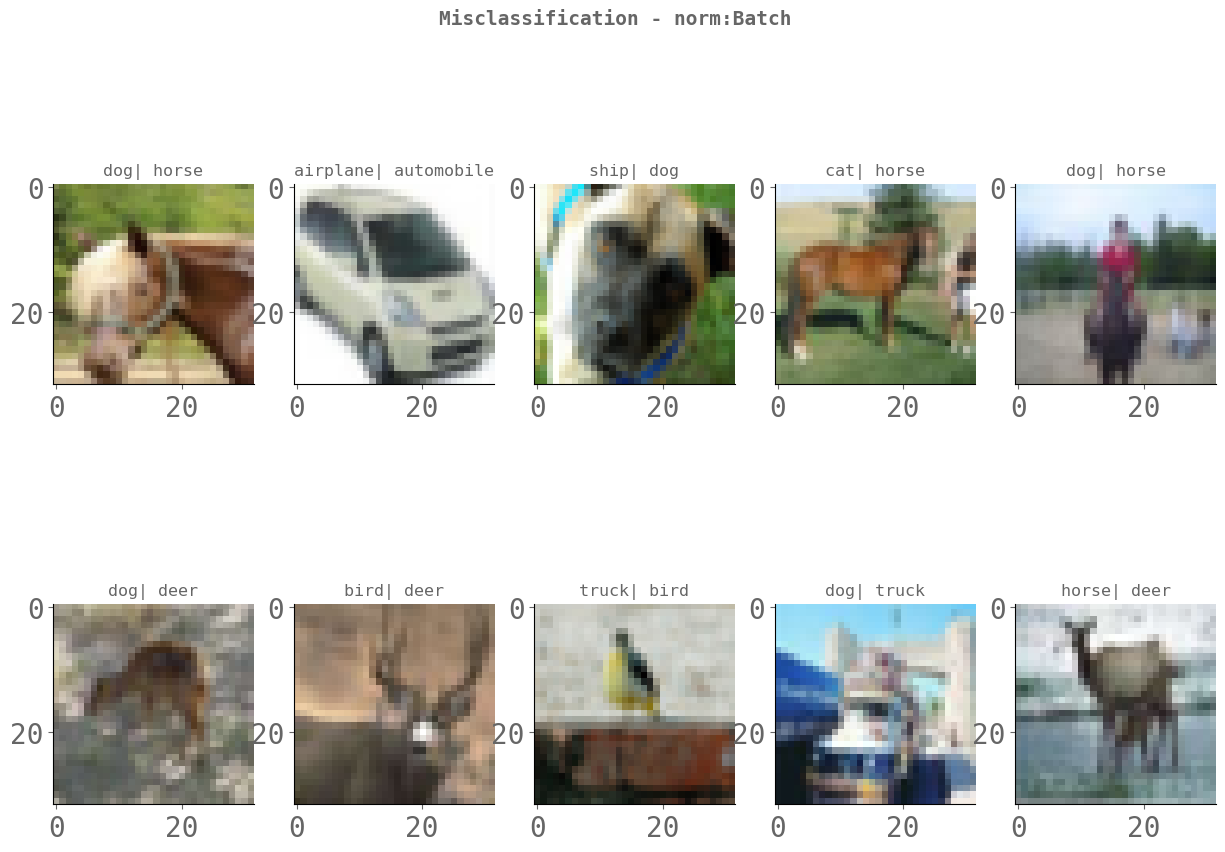

In [20]:
import matplotlib.pyplot as plt
nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 10), )
norm='Batch'
fig.suptitle(f"Misclassification - norm:{norm}", weight='bold', size=14)
samples = df.query("prediction != target").sample(10)
axes = axes.ravel()

plot_test_data = datasets.CIFAR10('./data', train=False, download=True,)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

for (ix, row), ax in zip(samples.iterrows(), axes):
    img = plot_test_data[ix][0]
    ax.imshow(img, interpolation='nearest')
    ax.set_title(f'{class_labels[row.prediction]}| {class_labels[row.target]}', fontsize=12)